## Simulate the runout of a 5 meter high pile of debris that suddenly collapses

### import necessary packages and components

In [1]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid
from landlab.components.mass_wasting_router import MassWastingRunout

### define the model domain, geometry of the pile and MassWastingRunout parameters Sc, qsi and k

In [2]:
# model domain
r = 51 # rows in model domain
c = r # columns
dxdy = 5 # cell size
hs = 1 # soil thickness
Dp = 0.2 # maximum particle diameter in soil

# define the pile
ls_h = 5 # height of pile
w = 5 # width of pile

# MassWastingRunout parameters
Sc = [0.03]  # critical slope
qsi = 0.01 # threshold flux
k = 0.02 # scour coefficient

### create model grid and add necessary grid fields

In [3]:
mg = RasterModelGrid((r,c),dxdy)

dem = mg.add_field('topographic__elevation',
                    np.ones(r*c)*1,
                    at='node')

mg.at_node['node_id'] = np.hstack(mg.nodes)
# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()
# set boundary conditions, add flow direction
mg.set_closed_boundaries_at_grid_edges(True, True, True, True) #close all boundaries
# flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()
# soil thickness
thickness = np.ones(mg.number_of_nodes)*hs
mg.add_field('node', 'soil__thickness',thickness)
# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp
# copy of initial topography
DEMi = mg.at_node['topographic__elevation'].copy()

### run flow director to add slope and receiving node fields

In [4]:
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
fd.run_one_step()

### create the pile

In [5]:
# find central point in domain
x = mg.node_x.max()/2
y = mg.node_y.max()/2

# find all nodes with radius of central point
dn = ((mg.node_x-x)**2+(mg.node_y-y)**2)**0.5
pile_nodes = np.hstack(mg.nodes)[dn<w*mg.dx]

# set those nodes as the landslide (they're all given the same mass__wasting_id number)
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][pile_nodes] = 1

# set thickness of landslide (in this case the pile)
mg.at_node['soil__thickness'][pile_nodes] = ls_h
mg.at_node['topographic__elevation'][pile_nodes] =   mg.at_node['topographic__elevation'][pile_nodes]+(ls_h-hs)

### take a look at the pile

Zmin1.0, Zmax5.0


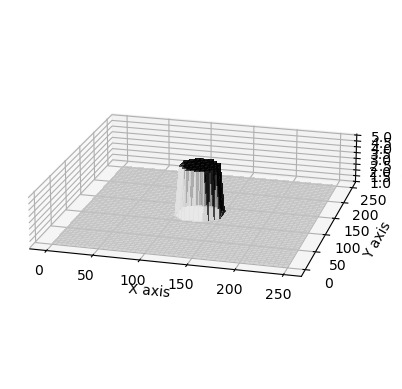

In [6]:
# borrow the plotting routine from the flow-director notebookks to make a 3d plot of our surface.
# import plotting tools
def surf_plot(mg,
              surface='topographic__elevation',
              title=''):

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    ax.set_box_aspect([1, 1, 0.2])
    plt.show()
    
surf_plot(mg)

### view a shaded hillshade of the map, colored according to elevation

<Axes: xlabel='Easting', ylabel='Northing'>

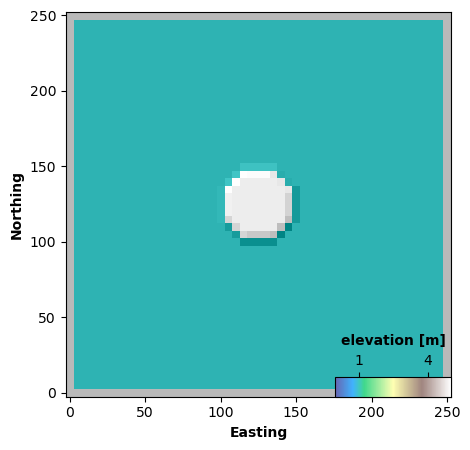

In [7]:
# 2d view
plt.figure(figsize = (5,5))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            cmap = 'terrain',
            var_name = 'elevation [m]',
            allow_colorbar=True,
            colorbar_label_y = -45,
            plot_type=  "Drape1",
            limits = (0,5),
            alpha = 0.75,
            altdeg=37., azdeg=210)

### that's a nice looking pile...now set up an instance of MassWastingRuntout to model its collapse and runout 

In [8]:
mw_dict = {'critical slope':Sc, 'threshold flux':qsi,
            'scour coefficient':k, 'effective particle diameter':Dp}
MWRu = MassWastingRunout(mg, mw_dict, effective_qsi = False, save = True, grain_shear = False, settle_deposit = True)

### run the instance of MassWastingRunout

In [9]:
start_time = time.time()
MWRu.run_one_step(run_id = 0)

### view runout extent

Zmin1.0, Zmax2.493460513790849


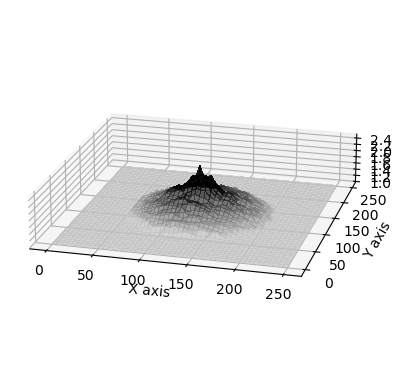

In [10]:
# 3d view
surf_plot(mg)

<Axes: xlabel='Easting', ylabel='Northing'>

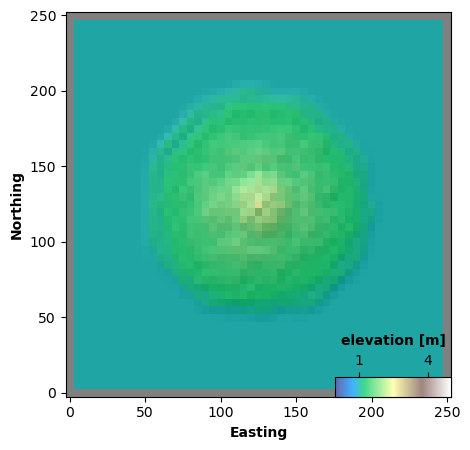

In [11]:
#shaded hillshade, colored by elevation
plt.figure(figsize = (5,5))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            cmap = 'terrain',
            var_name = 'elevation [m]',
            allow_colorbar=True,
            colorbar_label_y = -45,
            plot_type=  "Drape1",
            limits = (0,5),
            alpha = 0.75,
            altdeg=37., azdeg=210)

### view topographic change caused by the runout

<Axes: xlabel='Easting', ylabel='Northing'>

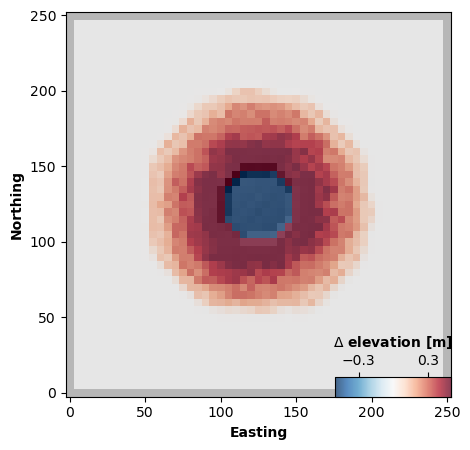

In [12]:
mg.at_node['dem_dif_o'] = mg.at_node['topographic__elevation']-mg.at_node['topographic__initial_elevation']

plt.figure(figsize = (5,5))
imshowhs_grid(mg,
            'dem_dif_o',
            drape1 = 'dem_dif_o',
            cmap = 'RdBu_r',
            var_name = r'$\Delta$ elevation [m]',
            allow_colorbar=True,
            colorbar_label_y = -45,
            plot_type=  "Drape1",
            limits = (-0.5,0.5),
            alpha = 0.75,
            altdeg=37., azdeg=210)


### view of the pile as it ranout

#### first in 3d view

Zmin1.0, Zmax5.0


<Figure size 1200x1200 with 0 Axes>

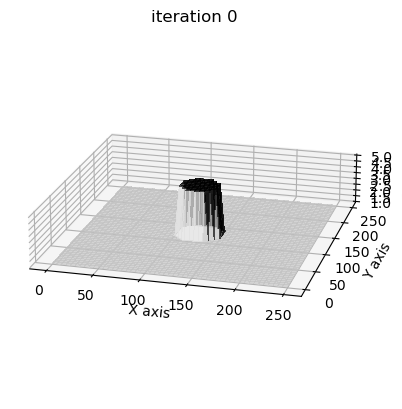

Zmin1.0, Zmax5.0


<Figure size 1200x1200 with 0 Axes>

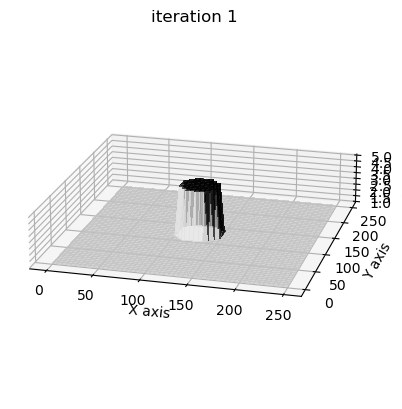

Zmin1.0, Zmax5.0


<Figure size 1200x1200 with 0 Axes>

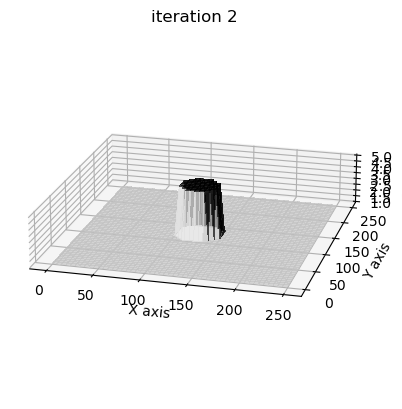

Zmin1.0, Zmax7.374985510076662


<Figure size 1200x1200 with 0 Axes>

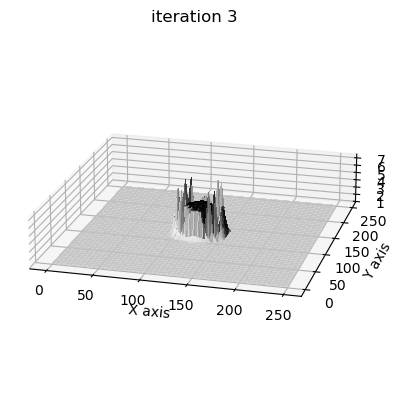

Zmin1.0, Zmax7.610168761058302


<Figure size 1200x1200 with 0 Axes>

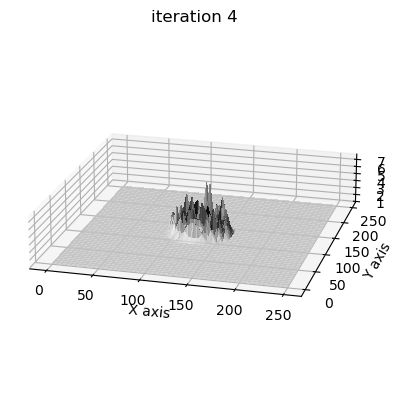

Zmin1.0, Zmax5.023236504017238


<Figure size 1200x1200 with 0 Axes>

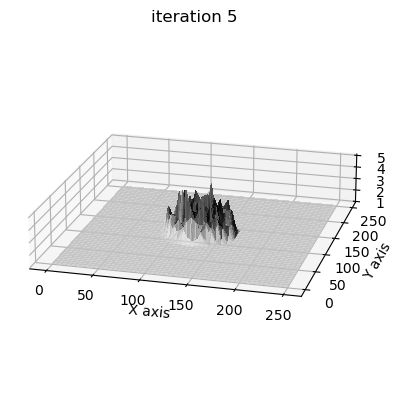

Zmin1.0, Zmax4.48115374776801


<Figure size 1200x1200 with 0 Axes>

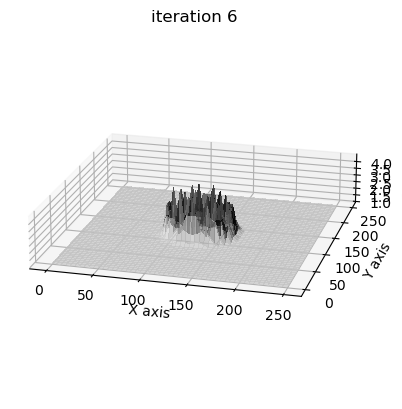

Zmin1.0, Zmax4.9059786363666875


<Figure size 1200x1200 with 0 Axes>

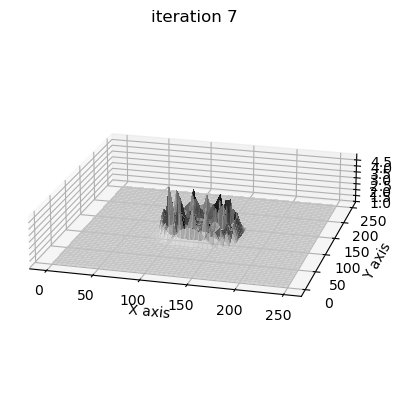

Zmin1.0, Zmax3.6605279590238746


<Figure size 1200x1200 with 0 Axes>

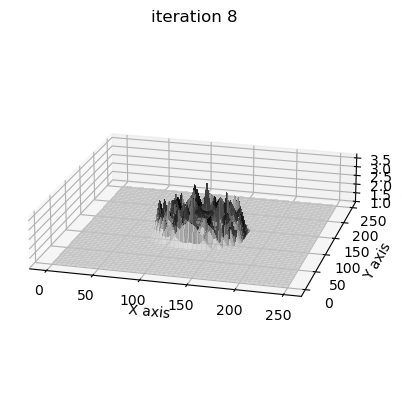

Zmin1.0, Zmax2.78063047393087


<Figure size 1200x1200 with 0 Axes>

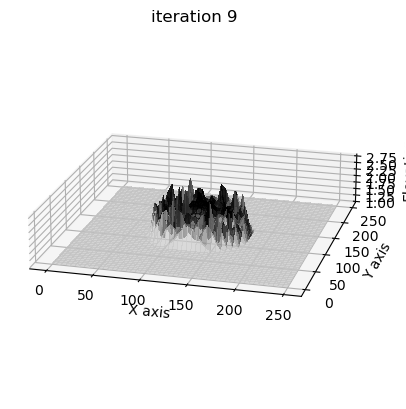

Zmin1.0, Zmax2.623622096559091


<Figure size 1200x1200 with 0 Axes>

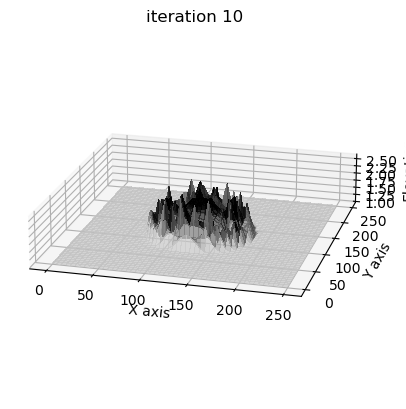

Zmin1.0, Zmax3.4072266925773813


<Figure size 1200x1200 with 0 Axes>

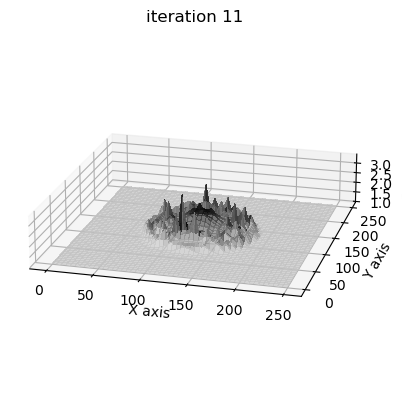

Zmin1.0, Zmax2.6569564621478516


<Figure size 1200x1200 with 0 Axes>

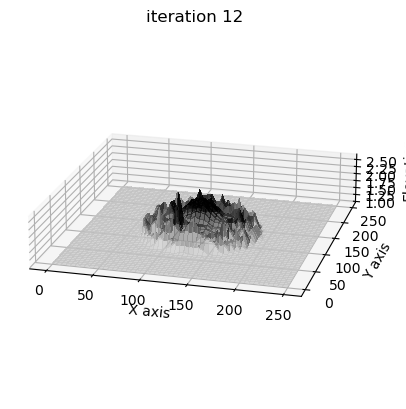

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

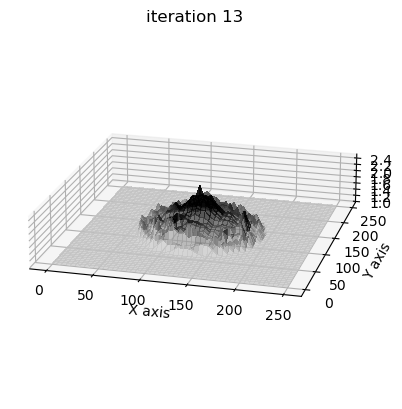

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

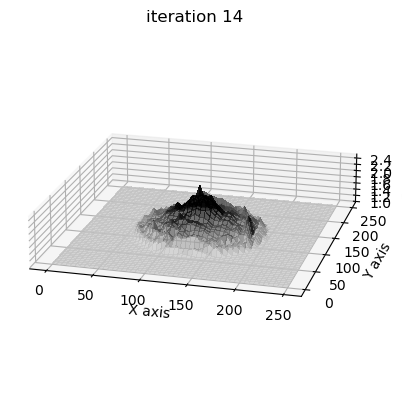

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

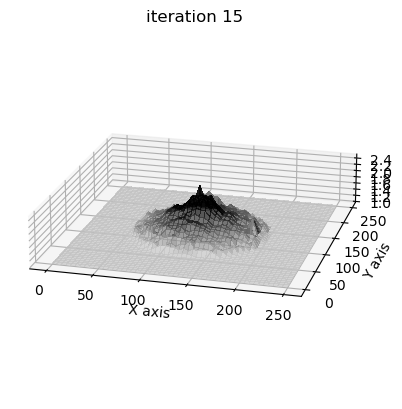

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

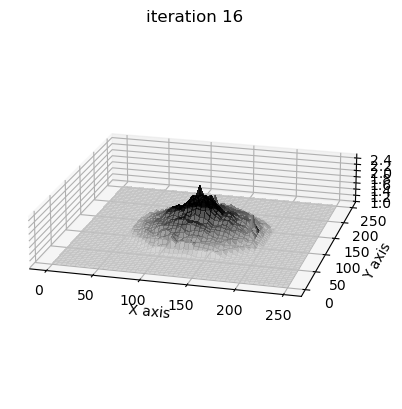

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

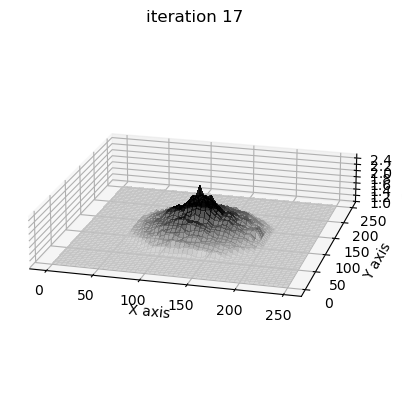

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

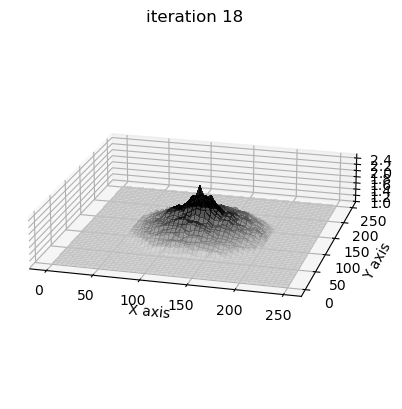

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

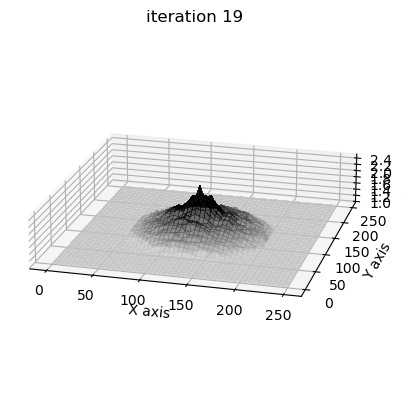

Zmin1.0, Zmax2.493460513790849


<Figure size 1200x1200 with 0 Axes>

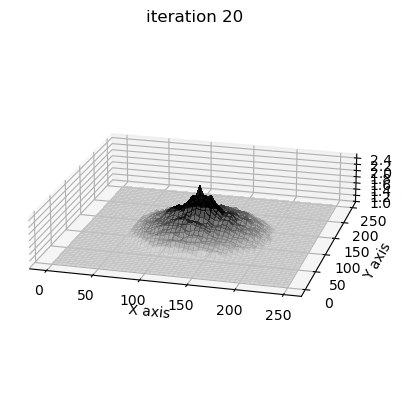

In [13]:
# plot how DEM changes
for i in np.arange(0,len(MWRu.mw_ids)):
    for c in MWRu.runout_evo_maps[i].keys():                  
        plt.figure('topography'+str(c)+str(i),figsize=(12, 12))
        mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[i][c]
        # imshow_grid_at_node(mg,'df_topo',cmap ='RdBu_r')  
        #LLT.plot_node_field_with_shaded_dem(mg,field = 'df_topo', fontsize = 10,cmap = 'RdBu_r', plot_name = 'topo + thick{},{}'.format(i,c) )
        field = "node_id"
        #plt.figure(figsize = (7,7))
        
        surf_plot(mg, 'topographic__elevation', 'iteration '+str(c))

In [17]:
# borrow the plotting routine from the flow-director notebookks to make a 3d plot of our surface.
# import plotting tools
def surf_plot(mg,
              surface='topographic__elevation',
              title=''):

    #fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    ax.set_box_aspect([1, 1, 0.2])
    plt.show()
    return surf

surf_plot(mg)

Zmin1.0, Zmax5.0


<IPython.core.display.Javascript object>


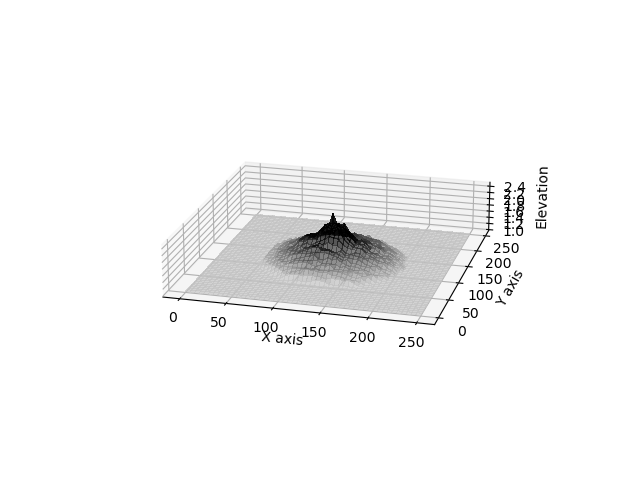

Zmin1.0, Zmax5.0


In [18]:
# modified
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook
def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][frame_number]
    plot[0].remove()
#    plot[0] = ax.plot_surface(np.reshape(MWRu._grid.node_x,mg.shape),
#                              np.reshape(MWRu._grid.node_y,mg.shape),
#                              np.reshape(MWRu.runout_evo_maps[0][frame_number],mg.shape)                             )
    plot[0] = surf_plot(mg ,'topographic__elevation')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

nmax=50
#plot = [ax.plot_surface(np.reshape(MWRu._grid.node_x,mg.shape), np.reshape(MWRu._grid.node_y,mg.shape), np.reshape(MWRu.runout_evo_maps[0][1],mg.shape), color='0.75', rstride=1, cstride=1)]
#ax.set_zlim(0,1.5)
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
plot = [surf_plot(mg ,'topographic__elevation')]
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot))
plt.show()

<IPython.core.display.Javascript object>


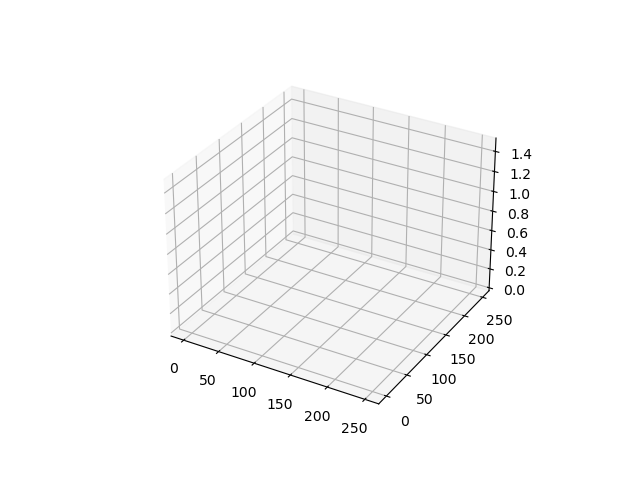

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook
def update_plot(frame_number, MWRu, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(np.reshape(MWRu._grid.node_x,mg.shape),
                              np.reshape(MWRu._grid.node_y,mg.shape),
                              np.reshape(MWRu.runout_evo_maps[0][frame_number],mg.shape)
                             )

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

nmax=50
plot = [ax.plot_surface(np.reshape(MWRu._grid.node_x,mg.shape), np.reshape(MWRu._grid.node_y,mg.shape), np.reshape(MWRu.runout_evo_maps[0][1],mg.shape), color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.5)
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot))
plt.show()

In [ ]:
plt.figure()
plot = [ax.plot_surface(np.reshape(MWRu._grid.node_x,mg.shape), np.reshape(MWRu._grid.node_y,mg.shape), np.reshape(MWRu.runout_evo_maps[0][1],mg.shape), color='0.75', rstride=1, cstride=1)]
#ax.set_zlim(0,1.5)

In [ ]:
np.reshape(MWRu.runout_evo_maps[0][0],mg.shape).shape

In [ ]:
MWRu._grid.node_x.shape

In [ ]:
MWRu.runout_evo_maps[0]

import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()

plt.figure('topography'+str(0)),figsize=(12, 12))
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
field = "node_id"
surf_plot(mg, 'topographic__elevation', 'iteration '+str(0))


def update(frame):
    # for each frame, update the data stored on each artist.
    mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][frame]
    surf_plot(mg, 'topographic__elevation', 'iteration '+str(frame))

    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)

#### now in 2d view

In [ ]:
# plot how DEM changes
for i in np.arange(0,len(MWRu.mw_ids)):
    for c in MWRu.runout_evo_maps[i].keys():                  
        plt.figure('topography'+str(c)+str(i),figsize=(12, 12))
        mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[i][c]
        field = "node_id"
        plt.figure(figsize = (5,5))
        
        ax = imshowhs_grid(mg,
                    'topographic__elevation',
                    drape1 = 'topographic__elevation',
                    plot_name = 'iteration '+str(c),
                    cmap = 'terrain',
                    var_name = 'elevation [m]',
                    allow_colorbar=True,
                    colorbar_label_y = -45,
                    plot_type=  "Drape1",
                    limits = (0,5),
                    alpha = 0.75,
                    altdeg=37., azdeg=210)


#### and finally, in profile view

In [ ]:
pf = mg.nodes[int((r-1)/2),:]
x_ = mg.node_x[pf]
y = mg.at_node['topographic__initial_elevation'][pf]
for i in np.arange(0,len(MWRu.mw_ids)):
    for c in MWRu.runout_evo_maps[i].keys():                  
        etopo = MWRu.runout_evo_maps[i][c]#-mg.at_node['topographic__initial_elevation']
        topo = MWRu.topo_evo_maps[i][c]               
        y_ = topo[pf]
        _y_ = etopo[pf]
        d = _y_ - y_; _y_[d == 0] = np.nan
        plt.figure(figsize = (5,2.5))
        plt.plot(x_,y,'k--', alpha = 0.5, linewidth = 1,label = 'initial ground profile')
        plt.plot(x_,y_,'g-', alpha = 0.5, linewidth = 1, label = 'ground profile, next iteration')
        plt.plot(x_,_y_,'r-', alpha = 0.5, linewidth = 1, label = 'debriton surface')
        plt.ylim(0,ls_h*3); plt.ylabel(' elevation ')
        plt.xlim([0, max(mg.node_x)])
        plt.legend()
        plt.grid(alpha = 0.5)  
        plt.title('iteration '+str(c))


In [ ]:
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Create some data
x = np.linspace(0, 2 * np.pi, 100)
y_initial = np.sin(x)
frames = 50
offsets = np.linspace(0, 2 * np.pi, frames)

# Create the figure and axis
fig, ax = plt.subplots()
line, = ax.plot(x, y_initial)

# Update function for the animation
def update(frame):
    y = np.sin(x + offsets[frame])
    line.set_ydata(y)
    return line,

# Create the animation
animation = FuncAnimation(fig, update, frames=frames, interval=100)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
%matplotlib notebook

fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

In [ ]:
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

In [ ]:
z

In [ ]:
z[0]

In [ ]:
zarray[:,:,0].shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N = 14
nmax=20
x = np.linspace(-4,4,N+1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N+1, N+1, nmax))

f = lambda x,y,sig : 1/np.sqrt(sig)*np.exp(-(x**2+y**2)/sig**2)

for i in range(nmax):
    zarray[:,:,i] = f(x,y,1.5+np.sin(i*2*np.pi/nmax))

plot = [ax.plot_surface(x, y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.5)
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(zarray, plot))
plt.show()

In [ ]:
x